## Contextual bandit (LinUCB)
---

From the paper : 

Li, L., Chu, W., Langford, J., & Schapire, R. E. (2010, April). A contextual-bandit approach to personalized news article recommendation. In Proceedings of the 19th international conference on World wide web (pp. 661-670). ACM.

[Link to paper](http://rob.schapire.net/papers/www10.pdf)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Defining constants

In [44]:
N_TRIAL = 4000
N_ARMS = 16
N_FEATURE = 5
BEST_ARMS = [3, 7, 9, 15]

### 1. Problem setting

#### Setting problems parameters

In [82]:
def make_design_matrix(n_trial, n_arms, n_feature):
    available_arms = np.arange(n_arms)
    X = np.array([[np.random.uniform(low=0, high = 1, size=n_feature) for _ in available_arms] for _ in np.arange(n_trial)])
    return X

def make_theta(n_arms, n_feature, best_arms, bias = .75) :
    true_theta = np.array([np.random.normal(loc = 0, scale=.25 ,size = n_feature) for _ in np.arange(n_arms)])
    true_theta[best_arms] = true_theta[best_arms] + bias
    return true_theta

def generate_reward(arm, x, theta, scale_noise = 1/10):
    signal = theta[arm].dot(x)
    noise  = np.random.normal(scale = scale_noise) 
    return (signal + noise)

def make_regret(payoff, oracle):
    return np.cumsum(oracle - payoff)

#### Simulation of design matrix and weight vector (theta)

In [83]:
X = make_design_matrix(n_trial = N_TRIAL, n_arms = N_ARMS, n_feature = N_FEATURE)
true_theta = make_theta(n_arms = N_ARMS, n_feature = N_FEATURE, best_arms = BEST_ARMS, bonus = 1.25)

#### Graphical representation of average payoff per arm

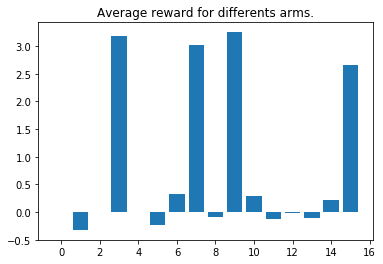

In [84]:
ave_reward = np.mean([[generate_reward(arm=arm, x=X[t, arm], theta=true_theta) \
                       for arm in np.arange(N_ARMS)] \
                      for t in np.arange(N_TRIAL)], axis = 0)
plt.bar(np.arange(N_ARMS), ave_reward)
plt.title("Average reward for differents arms.")
plt.show()

### 2. Algorithm (disjoint version)
#### Algorithm definition

In [85]:
def linUCB_disjoint(alpha, X, generate_reward, true_theta):
    print("linUCB disjoint with exploration parameter alpha: ", alpha)
    n_trial, n_arms, n_feature = X.shape
    
    # 1.Initialise object
    # 1.1.output object
    arm_choice, r_payoff = [np.empty(n_trial) for _ in range(2)]
    theta  = np.empty(shape=(n_trial, n_arms, n_feature)) #n_trial pour assurer la traçabilité. Il y a bien un vecteur théta par bras
    p      = np.empty(shape=(n_trial, n_arms)) #n_trial pour la traçabilité
    
    # 1.2.intermediate object
    A = np.array([np.diag(np.ones(shape=n_feature)) for _ in np.arange(n_arms)])
    b = np.array([np.zeros(shape=n_feature) for _ in np.arange(n_arms)])

    # 2. Algo
    for t in np.arange(n_trial):
        
        #Compute estimates (theta) and prediction (p) for all arms
        for a in np.arange(n_arms) :
            inv_A       = np.linalg.inv(A[a]) # caching matrix inversion result because used twice
            theta[t, a] = inv_A.dot(b[a])
            p[t, a]     = theta[t, a].T.dot(X[t, a]) + alpha * np.sqrt(X[t, a].T.dot(inv_A).dot(X[t, a]))
        
        #chosing best arms
        chosen_arm    = np.argmax(p[t])
        x_chosen_arm  = X[t, chosen_arm]
        r_payoff[t]   = generate_reward(arm=chosen_arm, x=x_chosen_arm, theta=true_theta)
        arm_choice[t] = chosen_arm
        
        #update intermediate objects (A and b)
        A[chosen_arm] += np.outer(x_chosen_arm, x_chosen_arm.T)
        b[chosen_arm] += r_payoff[t] * x_chosen_arm
    
    return dict(theta=theta, p=p, arm_choice = arm_choice, r_payoff=r_payoff)

#### Defining oracle and random payoff

In [86]:
oracle = np.array([np.max([generate_reward(arm=arm, x=X[t, arm], theta=true_theta) for arm in np.arange(N_ARMS)]) \
         for t in np.arange(N_TRIAL)])
payoff_random = np.array([generate_reward(arm=np.random.choice(N_ARMS), x=X[t, np.random.choice(N_ARMS)], theta=true_theta)\
                          for t in np.arange(X.shape[0])])
regret_random = make_regret(payoff=payoff_random, oracle = oracle)

#### Algorithm testing for various alpha

In [87]:
alpha_to_test = [0, 1, 2.5, 5, 10, 20]
res_various_alpha = [linUCB_disjoint(alpha = alpha, X=X, generate_reward=generate_reward, true_theta=true_theta) \
                     for alpha in alpha_to_test]

linUCB disjoint with exploration parameter alpha:  0
linUCB disjoint with exploration parameter alpha:  1
linUCB disjoint with exploration parameter alpha:  2.5
linUCB disjoint with exploration parameter alpha:  5
linUCB disjoint with exploration parameter alpha:  10
linUCB disjoint with exploration parameter alpha:  20


### 3. Analyzing regrets, coefficients estimates and chosen arms

#### 3.1. Representing regret according to various level of exploration value

(0, 1200)

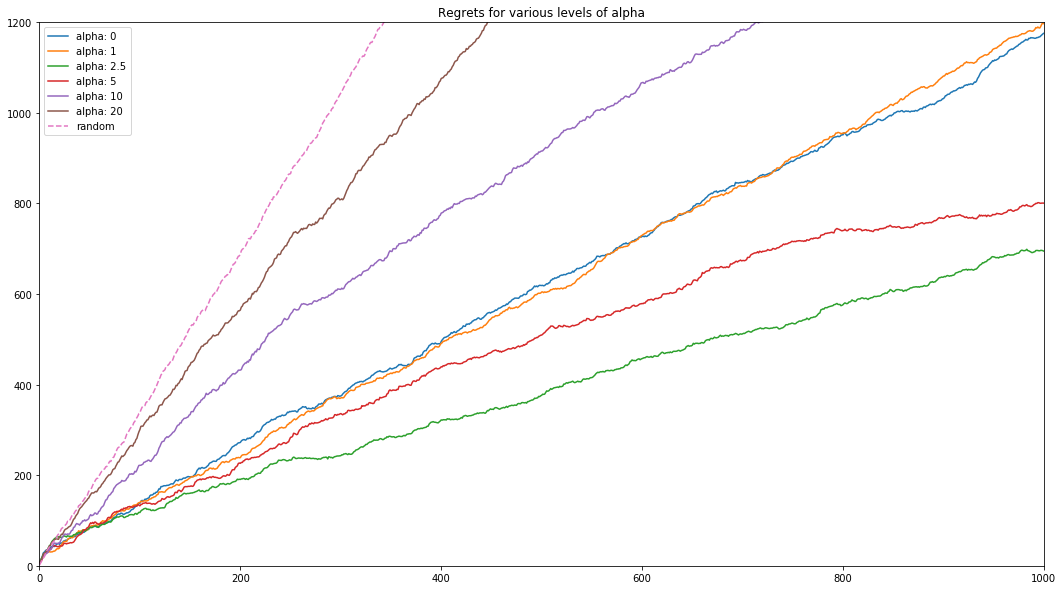

In [89]:
plt.figure(figsize = (18, 10))
[plt.plot(make_regret(payoff=x["r_payoff"], oracle = oracle), label = "alpha: " + str(alpha))\
 for (x, alpha) in zip(res_various_alpha, alpha_to_test)]
plt.plot(make_regret(payoff=payoff_random, oracle=oracle), label="random", linestyle='--')
plt.legend()
plt.title("Regrets for various levels of alpha")
plt.xlim([0, 1000])
plt.ylim([0, 1200])

#### 3.2. Coefficients path according to the time

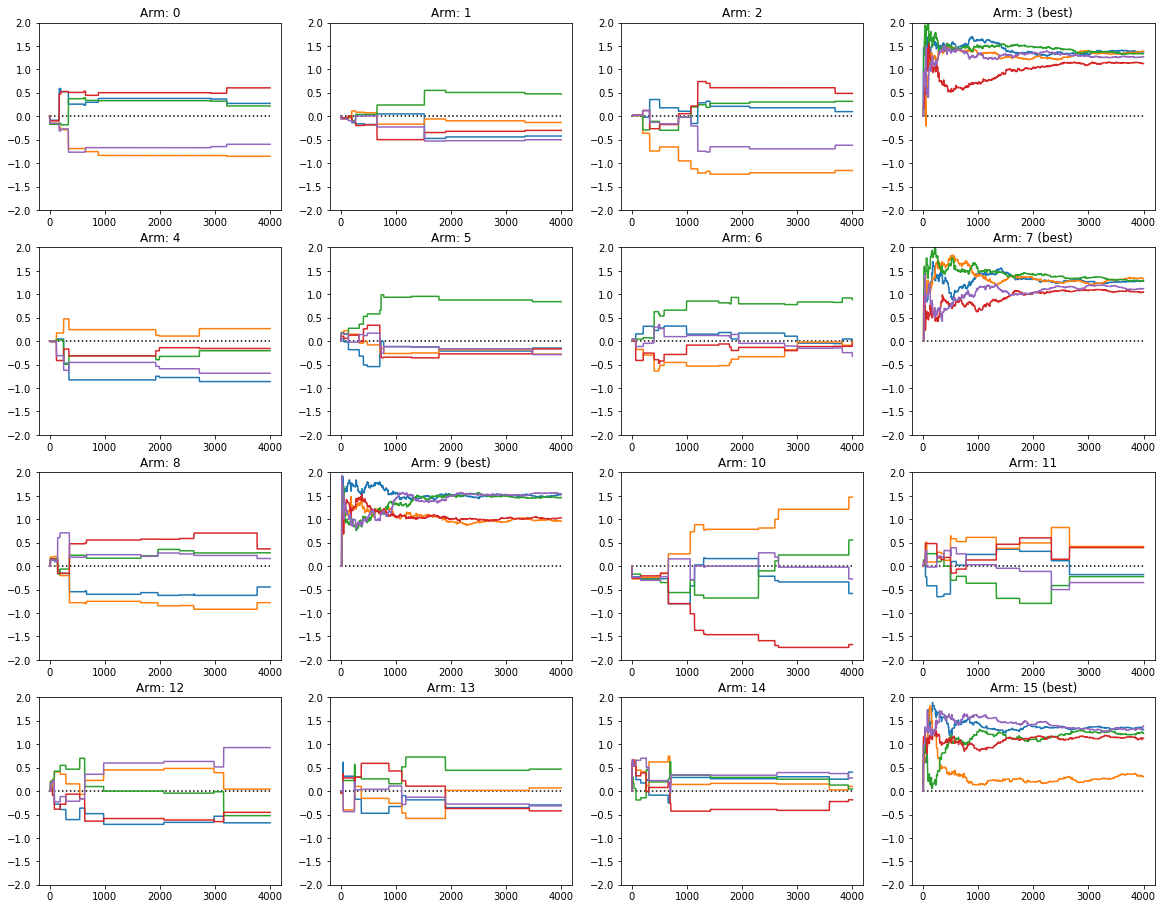

In [90]:
plt.figure(figsize = (20, 20))

for i, arm in enumerate(np.arange(N_ARMS)):
    plt.subplot(5, 4, 1 + i)
    plt.plot(pd.DataFrame(res_various_alpha[3]["theta"][:, arm, :]))
    plt.hlines(y=0, xmin = 0, xmax = N_TRIAL, linestyles=":")
    if (arm in BEST_ARMS) :
        title = "Arm: " + str(arm) + " (best)"
    else :
        title = "Arm: " + str(arm) 
    plt.title(title)
    plt.ylim([-2, 2])

#### 3.3. Number of time each arm has been selected

[<BarContainer object of 4 artists>,
 <BarContainer object of 10 artists>,
 <BarContainer object of 16 artists>,
 <BarContainer object of 16 artists>,
 <BarContainer object of 16 artists>,
 <BarContainer object of 16 artists>]

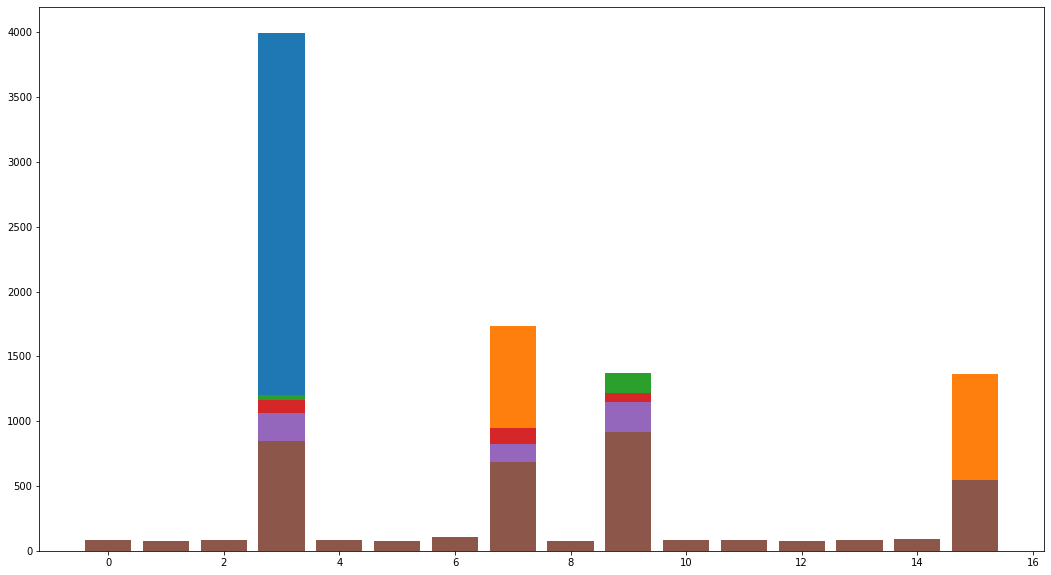

In [91]:
plt.figure(figsize = (18, 10))
[plt.bar(*np.unique(x["arm_choice"], return_counts=True)) for x in res_various_alpha]